In [15]:
import torch
import wandb
import pprint
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [16]:
import os
os.environ["http_proxy"]="http://proxy61.iitd.ac.in:3128"
os.environ["https_proxy"]="http://proxy61.iitd.ac.in:3128"

In [10]:
track_columns = ['new node test average_precision',
 'train roc_auc',
 'new node val first_3_roc_auc',
 'new node test first_3_roc_auc',
 'new node test first_3_average_precision',
 'new node val average_precision',
 'new node val first_1_average_precision',
 'new node test first_1_average_precision',
 'new node test first_1_roc_auc',
 'new node test first_10_roc_auc',
 'new node val first_3_average_precision',
 'val average_precision',
 'val roc_auc',
 'new node val roc_auc',
 'new node val first_10_average_precision',
 'new node test roc_auc',
 'train average_precision',
 'test roc_auc',
 'new node val first_1_roc_auc',
 'new node val first_10_roc_auc',
 'test average_precision',
 'new node test first_10_average_precision',
 'train_acc_hist',
 'val_acc_hist',
 'new node val_acc_hist',
 'test_acc_hist',
 'new node test_acc_hist',
 ]
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

for cnt, run in enumerate(tqdm(runs[:6])):
    # Find epoch with best avg precision
    update_run(run)

  0%|          | 0/6 [00:00<?, ?it/s]

tgn-ia-movielens-user2tags-10m-init-time-fourier
26
tgn-ia-slashdot-reply-dir-init-time-fourier
1
tgn-ia-escorts-dynamic-init-time-fourier
58
tgn-ia-digg-reply-init-time-fourier
10
tgn-ia-reality-call-init-time-fourier
97
tgn-ia-retweet-pol-init-time-fourier
52


In [4]:
def update_run(run):
  val_key = 'val average_precision'
  hist = run.history(samples = 200, keys = [val_key])
  hist= hist[val_key]
  best_epoch_num_test = np.argmax(hist[9::10])
  best_epoch_num = np.argmax(hist)
  print(run.name)
  print(best_epoch_num)
  for key in track_columns:
    hist = run.history(samples = 200, keys = [key])[key]
    # print(f"From {run.summary[key]} to ", end ="")
    if 'test' in key:
      run.summary[key] = hist[best_epoch_num_test]
      # print(f"{run.summary[key]}")
    else:
      run.summary[key] = hist[best_epoch_num]
      # print(f"{run.summary[key]}")
  run.summary.update()

### Plotting time transformation function

In [145]:
import sys
sys.path += ['/home/ayush/DyGLib/']
from models.MemoryModel import *
data_name = 'ia-slashdot-reply-dir'
run_name = "TGN_seed0_" + data_name + "nep-exp"
save_model_path = f"/home/ayush/DyGLib/saved_models/TGN/{data_name}/TGN_seed0_tgn-{data_name}-nep-exp/TGN_seed0_tgn-{data_name}-nep-exp.pkl"
dynamic_backbone = MemoryModel(node_raw_features=np.zeros((51085, 172)), edge_raw_features=np.zeros((1720, 10)), neighbor_sampler = None, time_feat_dim=100, model_name="TGN", num_layers=1, num_heads=2, dropout=0.1, total_time=1, use_init_method=True, init_weights='time-exp')
dynamic_backbone.mlp_for_mean = nn.Sequential(
            nn.Linear(dynamic_backbone.memory_dim, dynamic_backbone.memory_dim)
        )
link_predictor = MergeLayer(
                input_dim1=172,
                input_dim2=172,
                hidden_dim=172,
                output_dim=1,
            )
model = nn.Sequential(dynamic_backbone, link_predictor)
model.load_state_dict(torch.load(save_model_path, map_location=None))

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.mlp_for_mean.0.weight", "0.mlp_for_mean.0.bias". 
	size mismatch for 0.memory_updater.memory_updater.weight_ih: copying a param with shape torch.Size([516, 616]) from checkpoint, the shape in current model is torch.Size([516, 454]).
	size mismatch for 0.embedding_module.temporal_conv_layers.0.key_projection.weight: copying a param with shape torch.Size([272, 444]) from checkpoint, the shape in current model is torch.Size([272, 282]).
	size mismatch for 0.embedding_module.temporal_conv_layers.0.value_projection.weight: copying a param with shape torch.Size([272, 444]) from checkpoint, the shape in current model is torch.Size([272, 282]).

In [17]:
def get_table(filters, metrics, row_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  # Retrieve relevant runs
  return_runs = []
  for run in runs:
    flag = True
    for filter_key, filter_val in filters.items():
      if 'use_init_method' not in run.config:
        flag = False
      elif filter_key == 'run_name' and run.config['use_init_method'] == False:
        run.config['init_weights'] = "old"
      elif type(filter_val) == str and filter_val not in run.config[filter_key]:
        flag = False
      elif type(filter_val) != str and run.config[filter_key] == filter_val:
        flag = False
    if flag:
      return_runs.append(run)

  row_names = ["-".join([run.config[rn] for rn in row_name]) if row_name[0] in run.config else 'old' for run in return_runs ]
  for run in return_runs:
    if 'test average_precision' not in run.summary:
      x= 1
  return pd.DataFrame({metric: [round(100 * run.summary[metric], 2) for run in return_runs] for metric in metrics}, index = row_names)

In [18]:
def print_df_as_markdown(df):
    # Print header row
    df.sort_index(inplace = True)
    header = ["Index"] + list(df.columns)
    print("| " + " | ".join(header) + " |")
    
    # Print separator row
    print("| " + " | ".join([" --- " for _ in header]) + " |")
    
    # Print data rows
    for index, row in df.iterrows():
        data_row = [index]
        for col in df.columns:
            if row[col] == df[col].max():
                data_row.append("***" + str(row[col]) + "***")
            else:
                data_row.append(str(row[col]))
        print("| " + " | ".join(data_row) + " |")

In [19]:
"ia-movielens-user2tags-10m"

'ia-movielens-user2tags-10m'

In [32]:
table = get_table({"run_name": "nep-128", "dataset": "ia-reality-call"}, ["test average_precision", "new node test average_precision"], ["init_weights"])
print_df_as_markdown(table)

| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***97.3*** | ***94.69*** |
| time-fourier | 88.96 | 76.64 |


| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***89.46*** | ***87.12*** |
| time-exp | 86.75 | 80.34 |
| time-fourier | 86.46 | 79.0 |
| time-linear | 86.51 | 77.39 |
| time-mlp | 88.74 | 84.51 |

Index(['old', 'time-mlp'], dtype='object')

### Finding time transformation functions in models

## Generating combined histogram of acc v/s count for all nodes.

In [47]:
def smooth(tensor):
  smoothed_tensor = tensor.clone()
  for idx in range(len(tensor)):
    start_index = max(0, idx - 10)
    end_index = min(len(tensor), idx + 11)  # Adjusted to include the 10 elements after NaN
    
    # Smooth values using surrounding indices
    smoothed_value = torch.nanmean(tensor[start_index:end_index])
    
    # Replace NaN value with smoothed value
    smoothed_tensor[idx] = smoothed_value
  return smoothed_tensor.numpy()

In [48]:
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import torch

def generate_combine_hists(data_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  filt_runs = [run for run in runs if run.config['dataset'] == data_name][:5]
  # print(len(filt_runs), [run.id for run in filt_runs])
  for run in filt_runs:
    update_run(run)
  for hist_name in ['train_acc_hist', 'val_acc_hist', 'new node val_acc_hist', 'test_acc_hist', 'new node test_acc_hist']:
    plt.figure(figsize= (8, 6))
    plt.title(f"{hist_name} for {filt_runs[0].config['dataset']}")
    val_arr = []
    for run in filt_runs:
      hist = run.summary[hist_name]
      vals, bins = hist['values'], hist['bins']
      vals = [float(val) for val in vals]
      vals = smooth(torch.tensor(vals))
      val_arr.append(vals)
      # spl = make_interp_spline(bins[1:], vals, k=15)
      # x_new = np.linspace(bins[1], bins[-1], 200)
      # y_smooth = spl(x_new)
      # plt.plot(x_new, y_smooth)
      plt.plot(bins[1:], vals)
    plt.ylim([np.nanmin([np.nanmin(vals) for vals in val_arr]), 1])
    # plt.stackplot(bins[1:], val_arr[0], val_arr[1], step='post', labels=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    # plt.hist(val_arr, bins = bins, stacked=True, color = ['red', 'orange', 'green', 'blue', 'grey'], label=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    plt.legend(labels=["-".join(run.name.split("-")[len(data_name.split("-")) + 1:]) for run in filt_runs])
    plt.show()
    plt.close()

0
24
18
10
0


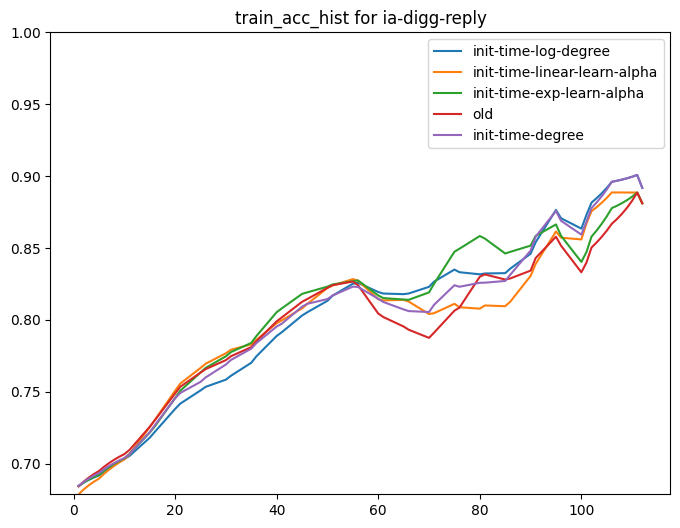

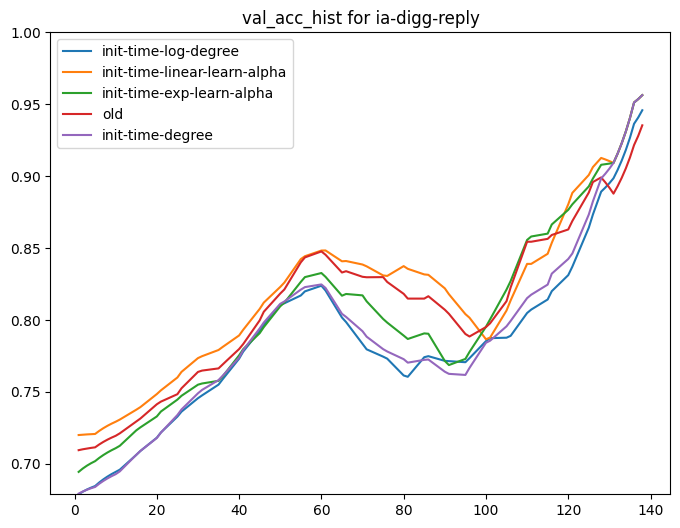

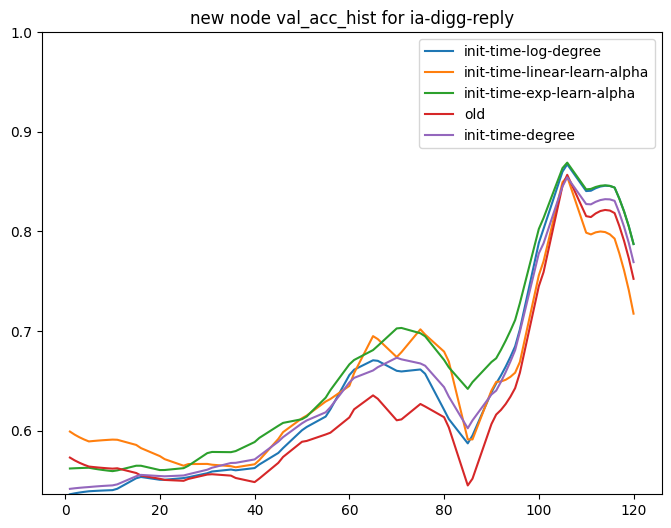

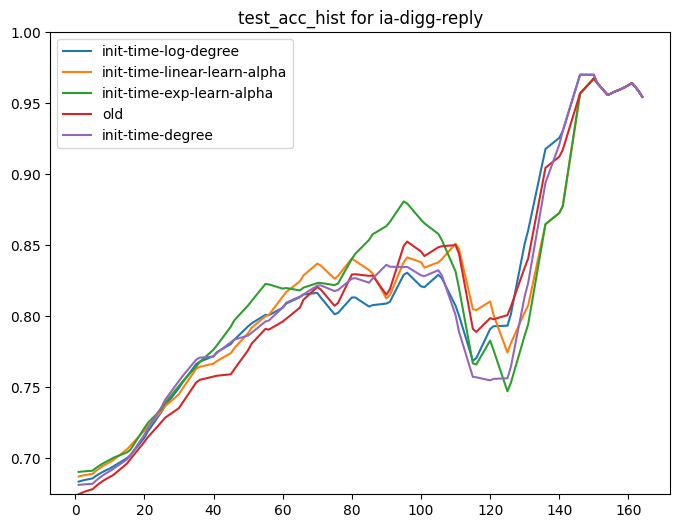

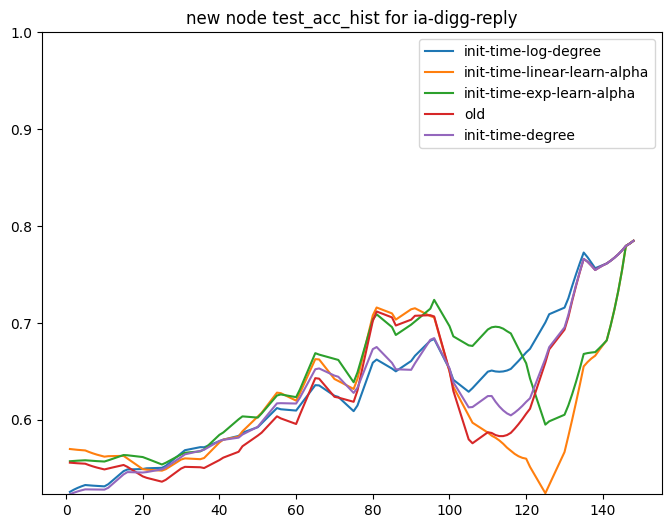

In [56]:
data_name = 'ia-digg-reply'
generate_combine_hists(data_name)

In [18]:
api = wandb.Api()
run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/jpp7vme0")
print(run.summary)
run.summary['test_loss'] = 0.2658
run.summary.update()

{'_timestamp': 1704864622.8613284, 'train_loss': {'min': 0.23194398468571345}, 'new node val average_precision': 0.9253885944374476, 'new node test average_precision': 0.9365360489713036, '_step': 41, 'test_loss': 0.2658, 'val average_precision': 0.9642710623015756, 'test average_precision': 0.9598691819415296, 'test roc_auc': {'max': 0.957818487394958}, 'train roc_auc': {'max': 0.9642339940649474}, 'new node test roc_auc': {'max': 0.9301795424690014}, 'train average_precision': 0.9642710623015756, '_wandb': {'runtime': 1468}, 'new node val_loss': {'min': 0.35462927964867136}, 'val roc_auc': {'max': 0.9642339940649474}, 'new node test loss': 0.3415547061269566, 'new node val roc_auc': {'max': 0.9190259221311476}, '_runtime': 1449.64683842659, 'val_loss': {'min': 0.255154035046321}}


In [10]:
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", filters = {'dataset': "reddit"})

In [12]:
len(runs)

HTTPError: 400 Client Error: Bad Request for url: https://api.wandb.ai/graphql

In [5]:
run = runs[0]

In [7]:
hist = run.history(samples = 200, keys = ['train_acc_hist'])['train_acc_hist']

In [13]:
vals, bins = hist[0]['values'], hist[0]['bins']

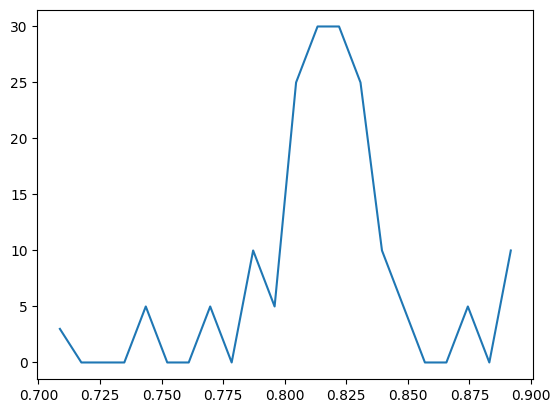

In [17]:
from matplotlib import pyplot as plt
plt.plot(bins[1:], vals)

In [23]:
runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

In [32]:
vals, bins

(array([4, 0, 1, 3, 4, 7, 0, 3, 2, 6]),
 array([0.00204809, 0.10064307, 0.19923805, 0.29783303, 0.39642801,
        0.495023  , 0.59361798, 0.69221296, 0.79080794, 0.88940292,
        0.9879979 ]))